#### Code to train models

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd ../src_det

/home/theo/Documents/kaggle_siim_covid/src_det


## Imports

In [3]:
import os
import cv2
import glob
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle

In [4]:
from data.transforms import get_transfos_lung
from data.dataset import LungDataset

from util.plot import plot_sample
from util.logger import prepare_log_folder, save_config, create_logger
from training.main import train

from params import *

## Data

In [5]:
CXR_PATH = "../input/lungs/cxr_dataset/"

In [6]:
SIIM_PATH = "../input/lungs/siim/"

In [7]:
boxes_dic_cxr = json.load(open('../output/boxes_cxr.json', 'r'))
boxes_dic_siim = json.load(open('../output/boxes_siim.json', 'r'))

In [8]:
GENERATE = False

### CXR

In [9]:
if GENERATE:
    imgs = glob.glob(CXR_PATH + "*/*.png")
    boxes_dic_cxr = {}

    for i, img_path in tqdm(enumerate(imgs)):

        base, img_name = img_path.split('/')[-2:]

        mask_path = CXR_PATH + "mask/" + base + "/" + img_name

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        n_components, comps, boxes, _ = cv2.connectedComponentsWithStats(mask[:, :, 0])

        boxes = np.array(boxes)[1:, :-1]
        boxes = boxes[boxes[:, 2] > 100]
        boxes = boxes[boxes[:, 3] > 100]

        if len(boxes) != 2:
            continue
            print(boxes)
    #         continue

        if not i % 100:
            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            plt.imshow(mask, alpha=0.2)

            for box in boxes:
        #         print(box)
                rect = Rectangle(
                    (box[0], box[1]), box[2], box[3],
                    linewidth=2, edgecolor='salmon', facecolor='none'
                )
                plt.gca().add_patch(rect)
            plt.axis(False)
            plt.show()

        boxes_dic_cxr[img_path] = boxes.astype(int).tolist()

    with open('../output/boxes_cxr.json', 'w') as f:
        json.dump(boxes_dic_cxr, f)

### Siim-covid

In [10]:
if GENERATE:

    DATA_PATH = "../input/"
    
    df = pd.concat([
        pd.read_csv('../input/df_train_512.csv'),
        pd.read_csv('../input/df_test_512.csv'),
    ])

    imgs = glob.glob(SIIM_PATH + "images/*/*.jpg")
    imgs_proc = glob.glob(DATA_PATH + "train_512/*") + glob.glob(DATA_PATH + "test_512/*")
    boxes_dic_siim = {}

    for i, img_path in tqdm(enumerate(imgs)):
        base, img_name = img_path.split('/')[-2:]

        img_path = [f for f in imgs_proc if img_name.split('.')[0] in f][0]

        crops, orig_shape, orig_shape_crop = df[df['save_name'] == img_path.split('/')[-1]][
            ['crop_starts', 'shape', 'shape_crop']
        ].values[0]
        crops = np.array(crops[1:-1].split(', ')).astype(int)
        orig_shape = np.array(orig_shape[1:-1].split(', ')).astype(int)
        orig_shape_crop = np.array(orig_shape_crop[1:-1].split(', ')).astype(int)

        img = cv2.imread(img_path)

        box_path = SIIM_PATH + "labels/" + base + "/" + img_name.split('.')[0] + ".txt"

        if not os.path.exists(box_path):
            print(box_path)
    #         continue

        boxes = open(box_path, 'r').readlines()
        boxes = np.array([np.array(b[:-1].split(' ')).astype(float) for b in boxes])
        boxes = boxes[boxes[:, 0] < 2][:, 1:]

        h, w, _ = img.shape

    #     orig_shape_crop =  orig_shape - crops * 1.5

        if crops.max():
            boxes[:, [2, 0]] *= orig_shape[1]
            boxes[:, [3, 1]] *= orig_shape[0]

            boxes[:, 0] -= crops[1]
            boxes[:, 1] -= crops[0]

            boxes[:, [2, 0]] /= orig_shape_crop[1]
            boxes[:, [3, 1]] /= orig_shape_crop[0]


        if crops.max() > 300:
            print(orig_shape, crops)
            print(orig_shape_crop[1] / orig_shape[1], orig_shape_crop[0] / orig_shape[0])

            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            for box in boxes:

                rect = Rectangle(
                    ((box[0] - box[2] / 2) * w, (box[1] - box[3] / 2) * h), box[2] * w, box[3] * h,
                    linewidth=2, edgecolor='salmon', facecolor='none'
                )
                plt.gca().add_patch(rect)
            plt.axis(False)
            plt.show()        

        boxes_dic_siim[img_path] = boxes.tolist()

    del boxes_dic_siim["../input/train_512/db5be2895a72_5cb08cd3bea3.png"]
    with open('../output/boxes_siim.json', 'w') as f:
        json.dump(boxes_dic_siim, f)

## Datasets

In [11]:
transforms = get_transfos_lung(augment=True, bbox_format="yolo")

In [12]:
dataset = LungDataset(
    boxes_dic_cxr,
    boxes_dic_siim,
    bbox_format="yolo",
    transforms=transforms
)

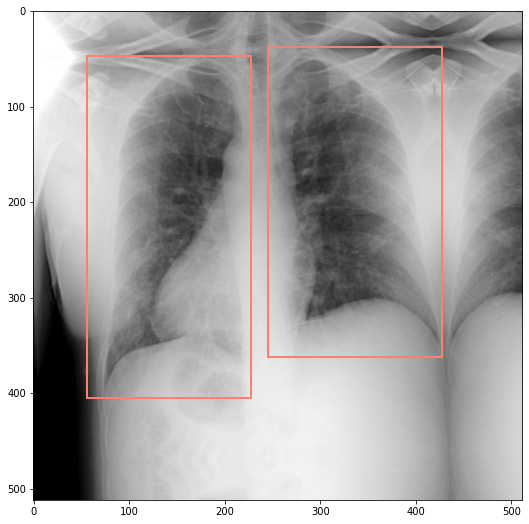

In [13]:
for i in np.random.choice(len(dataset), 3):
# for i in range(1):
    i = 609
    img, boxes, _ = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(9, 9))
    plot_sample(img, boxes, bbox_format="yolo", axis=True)
    plt.show()
    
    break

## Training

In [14]:
BATCH_SIZES = {
    "yolov5s": 32,
    "efficientdet_d0": 16,
    "efficientdet_d1": 16,
}

In [15]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    img_folder = "../data/processed/"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True
    first_epoch_eval = 3
    verbose_plot = 0
    
    # k-fold
    k = 5
    selected_folds = [0]
    
    # Model
    selected_model = "yolov5s"
#     selected_model = "efficientdet_d1"
    bbox_format = "yolo" if "yolo" in selected_model else "pascal_voc"
    pred_format = "pascal_voc" #if "yolo" in selected_model else "coco"
    num_classes = 1
    
    # Loss (YOLO)
    gr = 1.0
    autobalance = False
    label_smoothing = 0
    box = 0.05  # box loss gain
    cls = 0.5  # cls loss gain
    cls_pw = 1.0  # cls BCELoss positive_weight
    obj = 1.0  # obj loss gain (scale with pixels)
    obj_pw = 1.0  # obj BCELoss positive_weight
    iou_t = 0.20  # IoU training threshold
    anchor_t = 4.0  # anchor-multiple threshold
    # anchors: 3  # anchors per output layer (0 to ignore)
    fl_gamma = 0.0  # focal loss gamma (efficientDet default gamma=1.5)
    
    # NMS
    conf_thresh = 0.5  # 0.1
    iou_thresh = 0.5

    # Training 
    optimizer = "Adam"
    momentum = 0.937
    weight_decay = 0.0005
    
    batch_size = BATCH_SIZES[selected_model]
    val_bs = batch_size
    
    epochs = 10
    lr = 5e-4
    warmup_prop = 0.1
    
#     mix = "cutmix"
#     mix_proba = 0.5
#     mix_alpha = 5
    mosaic_proba = 0

In [16]:
DEBUG = True
log_folder = None

In [ ]:
%matplotlib inline

if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH + "lungs/")
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

meter = train(Config, boxes_dic_cxr, boxes_dic_siim, log_folder=log_folder);

In [ ]:
meter.plot(-1)

## Inference

In [17]:
from data.dataset import InferenceDataset

from util.logger import Config
from util.torch_utils import load_model_weights

from model import define_model

from inference import predict

In [18]:
EXP_FOLDER = "../logs/lungs/2021-08-02/1/"

In [19]:
config = Config(json.load(open(EXP_FOLDER + "config.json", 'r')))

In [20]:
weights = sorted([EXP_FOLDER + p for p in os.listdir(EXP_FOLDER) if 'pt' in p])

In [21]:
model = define_model(
    config
).to(config.device)
model.zero_grad()

model.eval()

model.conf_thresh = 0.001

model = load_model_weights(model, weights[0])

Overriding model.yaml nc=80 with nc=1



 -> Loading weights from ../logs/lungs/2021-08-02/1/yolov5s.pt



In [58]:
TRAIN = False

if TRAIN:
    img_paths = glob.glob('../input/train_512/*.png')
else:
    img_paths = glob.glob('../input/test_512/*.png')

In [59]:
transforms = get_transfos_lung(augment=False, mean=model.mean, std=model.std, bbox_format=config.bbox_format)
dataset = InferenceDataset(img_paths, transforms)

In [60]:
meter = predict(model, dataset, config)

In [62]:
indices = [4, 98, 285, 395, 508, 835, 1142, 2033, 2851, 2905, 2927, 3089, 3365, 3378, 3675, 3910, 3928, 4102, 4236, 5045, 5064, 5197, 5489, 5949]
indices = [835, 2905, 3089, 3675]
indices = None

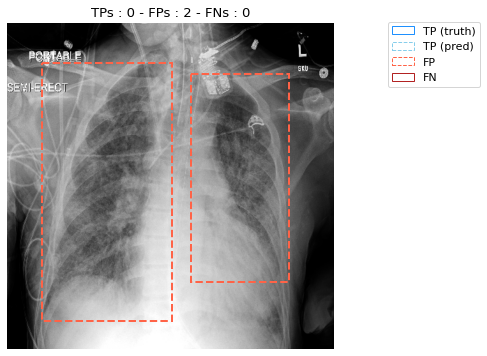

In [63]:
meter.plot(indices=indices)

In [64]:
meta = []
for img_path, boxes, conf in zip(img_paths, meter.preds, meter.confidences):
    box = boxes['albu']
    meta.append({
        "img_path": img_path,
        "img_name": img_path[:-4].split('_')[-1],
        "boxes": str(box.tolist()),
        "confidences": str(conf.tolist()),
    })

#     break

df_boxes = pd.DataFrame.from_dict(meta)

In [66]:
if TRAIN:
    df_boxes.to_csv('../output/lungs_train', index=False)
else:
    df_boxes.to_csv('../output/lungs_test', index=False)

# PP